In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob

import os
pd.set_option('display.max_columns', None)

**Load the data and prepare the initial train and test Dataframes**

During a quick initial correlation analysis, NaN values appeared despite the absence of missing data. This was traced to several sensors with constant readings across all cycles (zero variance), leading to undefined correlation coefficients. These sensors were subsequently removed from analysis, as they carry no predictive information. Specifically, the following sensor_1, sensor_5, sensor_6, sensor_10, sensor_16, sensor_18, sensor_19, and operating_setting_3, since it remains constant in half the subsets and fluctuates in the other half, are removed in the initial light cleaning of the datasets.

In [ ]:
def load_data(file_path:str, prefix:str)->pd.DataFrame:
    """
    Load and combine CMPASS training and testing subsets into a single DataFrame for both train and test datasets.
    Each subset is read, lightly cleaned, tagged with its subset id, and appended to a list. 
    The list is then concatenated into a single DataFrame.
    """
    all_data = []

    for i in range(1, 5):
        fname = f"{prefix}{i}.txt"
        fpath =os.path.join(file_path, fname)
        if not os.path.exists(fpath):
            print(f"File {fpath} does not exist. Please check the path and filename.")
            continue
        df = pd.read_csv(fpath, sep="\s+", header=None)        
        # Light cleaning: drop any empty space columns (if any)
        df.dropna(axis=1, how="all" ,inplace=True)
        # Tag with subset id
        df['subset'] = f'FD00{i}'
        # Append to list
        all_data.append(df)
        if not all_data:
            raise FileNotFoundError(f"No data files found for prefix: {prefix} in path: {file_path}")
    return pd.concat(all_data, ignore_index=True)

#Defining column names based on community conventions since they are not provided in the dataset
#or treated as proprietary information.
def add_column_names_and_drop_constant_columns(data:pd.DataFrame)->pd.DataFrame:
    """
    Add column names to the DataFrame based on community conventions.
    """
    base_cols = ['unit_number', 'time_in_cycles', 'operating_setting_1', 'operating_setting_2', 
    'operating_setting_3',
    ]
    sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
    full_cols = base_cols + sensor_cols + ['subset']
    data.columns = full_cols
    # Drop columns that are not useful for analysis
    drop_cols = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'operating_setting_3']
    data.drop(columns=drop_cols, inplace=True, errors='ignore')
    # Check for any columns that remain constant across the combined dataset
    #zero_var_cols_after = [col for col in data.columns if data[col].nunique(dropna=False) == 1 and col != 'subset']
    #if zero_var_cols_after:
    #    print(f"Warning! constant columns still exist: {zero_var_cols_after}")
    return data


<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\menge\AppData\Local\Temp\ipykernel_18660\4279855270.py:15: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(fpath, sep="\s+", header=None)


In [3]:
## Load and preprocess the data
train_data = load_data("../Prediction_Dataset/Turbofan_Engine_data_Set/", "train_FD00")
train_data = add_column_names_and_drop_constant_columns(train_data)

test_data = load_data("../Prediction_Dataset/Turbofan_Engine_data_Set/", "test_FD00")
test_data = add_column_names_and_drop_constant_columns(test_data)
#rul_data = pd.read_csv("../Prediction_Dataset/Turbofan_Engine_data_Set/", "RUL_FD00.txt")

**Exploratory Data Analysis**

For this stage it is necessary to calculate the RUL values for the train data and append the provided RUL of the test data.
This will be essential in the bivariate analysis. 

For training subsets, Remaining Useful Life (RUL) is derived directly as the difference between the maximum observed cycle and the current cycle per engine.
For test subsets, the provided NASA RUL ground-truth files are merged with test data to offset truncated sequences, ensuring consistent RUL definition across datasets.

In [4]:
#A function to calculate RUL for train data. We compute RUL manually for the train data.
def add_train_rul(data:pd.DataFrame)->pd.DataFrame:
    """
    Calculate Remaining Useful Life (RUL) for training data.
    RUL is derived as the difference between the maximum observed cycle and the current cycle per engine.
    """
    max_cycles = data.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']
    # Merge max_cycle back to original DataFrame
    data = data.merge(max_cycles, on='unit_number', how='left')
    # Compute RUL for each record
    data['RUL'] = data['max_cycle'] - data['time_in_cycles']
    # Drop helper column
    data.drop(columns=['max_cycle'], inplace=True)
    return data

def add_test_rul(data: pd.DataFrame, rul_file_path: str) -> pd.DataFrame:
    """
    We calculate remaining useful life (RUL) for test data using NASA ground-truth RUL files.
    Works across concatenated FD001–FD004 subsets by merging on (subset, unit_number).
    RUL at any time t = (RUL at last observed cycle) + (max_cycle - t)
    1. Load RUL ground-truth file, which has one RUL value per engine unit.
    2. Assign unit_number within each subset (RUL files are ordered by unit).
    3. Compute per-(subset, unit) max_cycle and join to data.
    4. Merge RUL truth per (subset, unit).
    5. Compute RUL at each cycle.
    6. Clean up helper columns.
    """
    # Load all RUL files; result has one unnamed column + 'subset'
    rul_df = load_data(rul_file_path, "RUL_FD00")

    # Ensure expected columns: [final_truth_rul, subset]
    # After load_data: the first column is the RUL values, second is 'subset'
    if rul_df.shape[1] != 2 or 'subset' not in rul_df.columns:
        # Be graceful: take the first non-'subset' column as the RUL column.
        non_subset_cols = [c for c in rul_df.columns if c != 'subset']
        if len(non_subset_cols) != 1:
            raise ValueError("Unexpected RUL file format.")
        rul_col = non_subset_cols[0]
        rul_df = rul_df.rename(columns={rul_col: 'final_truth_rul'})
    else:
        # columns are [0, 'subset']
        first_col = [c for c in rul_df.columns if c != 'subset'][0]
        rul_df = rul_df.rename(columns={first_col: 'final_truth_rul'})

    # Assign unit_number within each subset (RUL files are ordered by unit)
    rul_df['unit_number'] = rul_df.groupby('subset').cumcount() + 1

    # Compute per-(subset, unit) max_cycle and join to data
    data = data.copy()
    data['max_cycle'] = data.groupby(['subset', 'unit_number'])['time_in_cycles'].transform('max')

    # Merge RUL truth per (subset, unit)
    data = data.merge(
        rul_df[['subset', 'unit_number', 'final_truth_rul']],
        on=['subset', 'unit_number'],
        how='left'
    )

    # RUL at any time t = (RUL at last observed cycle) + (max_cycle - t)
    data['RUL'] = data['final_truth_rul'] + (data['max_cycle'] - data['time_in_cycles'])

    # Clean up helpers
    data.drop(columns=['final_truth_rul', 'max_cycle'], inplace=True)

    return data 

In [5]:
## Add RUL to train and test data
train_data = add_train_rul(train_data)
test_data = add_test_rul(test_data, "../Prediction_Dataset/Turbofan_Engine_data_Set/")


In [6]:
# Separate identifiers from features
# This is useful for modeling where we want to exclude identifiers from feature sets.
# This also helps avoid data leakage.

def separate_id_and_features(data:pd.DataFrame)->tuple[pd.DataFrame, pd.DataFrame]:
    """
    Separate identifier columns from feature columns.
    Identifier columns are those that uniquely identify each record and should not be used as features in modeling.
    """
    id_cols = ['unit_number', 'time_in_cycles', 'subset']
    feature_cols = [col for col in data.columns if col not in id_cols]
    return data[id_cols], data[feature_cols]
    

In [7]:
id_df, feature_df = separate_id_and_features(train_data)

****Basic Data Inspection****

In [8]:
train_data.head(4)

,unit_number,time_in_cycles,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,subset,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,FD001,320
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,FD001,319
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,FD001,318
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,FD001,317


In [9]:
test_data.head(4)

,unit_number,time_in_cycles,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,subset,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,FD001,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,FD001,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,FD001,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,FD001,139


In [10]:
train_data.describe()

,unit_number,time_in_cycles,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,105.553758,123.331338,17.211973,0.410004,597.361022,1467.035653,1260.956434,359.729968,2273.829707,8677.553696,44.212049,338.789821,2349.645243,8088.950972,9.054747,360.698801,25.942709,15.565700,169.215329
std,72.867325,83.538146,16.527988,0.367938,42.478516,118.175261,136.300073,174.133835,142.426613,374.657454,3.426342,164.193480,111.167242,80.623257,0.751581,31.021430,11.691422,7.015067,95.862031
min,1.000000,1.000000,-0.008700,-0.000600,535.480000,1242.670000,1023.770000,136.170000,1914.720000,7984.510000,36.040000,128.310000,2027.570000,7845.780000,8.156300,302.000000,10.160000,6.010500,0.000000
25%,44.000000,57.000000,0.001300,0.000200,549.960000,1357.360000,1126.830000,175.710000,2212.120000,8334.770000,42.010000,164.790000,2387.970000,8070.530000,8.439250,332.000000,14.330000,8.601300,97.000000
50%,89.000000,114.000000,19.998100,0.620000,605.930000,1492.810000,1271.740000,341.690000,2319.370000,8764.200000,44.930000,321.690000,2388.070000,8118.590000,9.030100,367.000000,24.920000,14.953500,163.000000
75%,164.000000,173.000000,35.001500,0.840000,642.340000,1586.590000,1402.200000,553.290000,2388.050000,9055.850000,47.340000,521.340000,2388.160000,8139.410000,9.344200,392.000000,38.820000,23.294600,230.000000
max,260.000000,543.000000,42.008000,0.842000,645.110000,1616.910000,1441.490000,570.810000,2388.640000,9244.590000,48.530000,537.490000,2390.490000,8293.720000,11.066900,400.000000,39.890000,23.950500,542.000000


In [11]:
train_data.isna().sum()

unit_number            0
time_in_cycles         0
operating_setting_1    0
operating_setting_2    0
sensor_2               0
sensor_3               0
sensor_4               0
sensor_7               0
sensor_8               0
sensor_9               0
sensor_11              0
sensor_12              0
sensor_13              0
sensor_14              0
sensor_15              0
sensor_17              0
sensor_20              0
sensor_21              0
subset                 0
RUL                    0
dtype: int64

In [12]:
test_data.isna().sum()

unit_number            0
time_in_cycles         0
operating_setting_1    0
operating_setting_2    0
sensor_2               0
sensor_3               0
sensor_4               0
sensor_7               0
sensor_8               0
sensor_9               0
sensor_11              0
sensor_12              0
sensor_13              0
sensor_14              0
sensor_15              0
sensor_17              0
sensor_20              0
sensor_21              0
subset                 0
RUL                    0
dtype: int64

In [13]:
train_data.dtypes

unit_number              int64
time_in_cycles           int64
operating_setting_1    float64
operating_setting_2    float64
sensor_2               float64
sensor_3               float64
sensor_4               float64
sensor_7               float64
sensor_8               float64
sensor_9               float64
sensor_11              float64
sensor_12              float64
sensor_13              float64
sensor_14              float64
sensor_15              float64
sensor_17                int64
sensor_20              float64
sensor_21              float64
subset                  object
RUL                      int64
dtype: object

In [14]:
test_data.dtypes

unit_number              int64
time_in_cycles           int64
operating_setting_1    float64
operating_setting_2    float64
sensor_2               float64
sensor_3               float64
sensor_4               float64
sensor_7               float64
sensor_8               float64
sensor_9               float64
sensor_11              float64
sensor_12              float64
sensor_13              float64
sensor_14              float64
sensor_15              float64
sensor_17                int64
sensor_20              float64
sensor_21              float64
subset                  object
RUL                      int64
dtype: object

In [15]:
train_data.subset.value_counts()

subset
FD004    61249
FD002    53759
FD003    24720
FD001    20631
Name: count, dtype: int64

The initial structural inspection of the NASA CMAPSS turbofan engine degradation dataset confirms that the data are complete, consistent, and analytically robust.

Missing Values: No missing or null entries were detected across all subsets, indicating strong data integrity and no need for imputation or record removal.

Data Types: All variables are of numeric type (float64 and int64), which ensures seamless compatibility with statistical modeling, scaling, and machine learning pipelines.

Subset Composition:
The combined dataset comprises four operational subsets, each representing distinct engine operating conditions and fault modes. Their record counts are as follows:

Subset	Record Count
FD001	20,631;
FD002	53,759;
FD003	24,720;
FD004	61,249;

The data distribution shows that subsets FD002 and FD004 contribute the largest volumes of records, corresponding to more complex operational conditions. This balanced yet diverse representation provides a solid foundation for developing and validating robust Remaining Useful Life (RUL) prediction models across multiple operating regimes.

In summary, the dataset exhibits high structural quality — fully numeric, complete, and well-balanced — supporting confidence in subsequent exploratory data analysis and model development.

****Data integrity and consistency check:****

In [16]:
#Check for duplicates
train_data.duplicated().sum()

np.int64(0)

In [17]:
# Range and domain validation
# Check that sensor readings and operating settings fall within expected ranges.
train_data.groupby('subset')[['time_in_cycles', 'subset']].describe()

time_in_cycles                                                       
                count        mean        std  min   25%    50%    75%    max
subset                                                                      
FD001         20631.0  108.807862  68.880990  1.0  52.0  104.0  156.0  362.0
FD002         53759.0  109.154746  69.180569  1.0  52.0  104.0  157.0  378.0
FD003         24720.0  139.077063  98.846675  1.0  62.0  124.0  191.0  525.0
FD004         61249.0  134.311417  89.783389  1.0  62.0  123.0  191.0  543.0

In [18]:
train_data.groupby('subset')['time_in_cycles'].max()

subset
FD001    362
FD002    378
FD003    525
FD004    543
Name: time_in_cycles, dtype: int64

The variable time_in_cycles represents the number of operational cycles an engine completed before failure (in the training data) or the end of monitoring (in the test data).
Engines in subsets FD003 and FD004 have longer lifespans, with maximum cycles exceeding 500, while those in FD001 and FD002 operate for shorter durations (max ~360 cycles).
Standard deviations are relatively large (≈70–100 cycles), confirming significant variability in engine lifetime even within the same subset.
This reflects real-world degradation variability — driven by differences in load, temperature, and environmental factors.
The mean operating life across subsets is broadly consistent (≈110–140 cycles), but subsets FD003 and FD004 show higher median and maximum values, aligning with their known greater fault complexity and multiple operating conditions.
This variation is advantageous for modeling, as it exposes predictive algorithms to a wide range of degradation behaviors.
It indicates that the dataset captures realistic operational diversity, strengthening the generalizability and commercial reliability of any predictive maintenance solution derived from it.
In summary, engine life cycles in the CMAPSS data vary considerably across subsets — from moderate durations under simpler conditions (FD001–FD002) to extended lifetimes under complex environments (FD003–FD004).
This diversity provides a rich basis for developing and validating robust Remaining Useful Life (RUL) estimation models across multiple operational regimes.

In [19]:
train_data['unit_number'].nunique()

260

In [20]:
train_data.groupby('subset')['unit_number'].nunique()

subset
FD001    100
FD002    260
FD003    100
FD004    249
Name: unit_number, dtype: int64

The CMAPSS dataset includes 260 unique turbofan engines across the four subsets, each representing a distinct set of operating conditions and fault modes.FD001 and FD003 each include 100 engines, typically associated with simpler fault modes and single operating conditions.

FD002 and FD004 include more engines (249–260), representing more complex fault scenarios and multiple operating conditions.
These subsets are designed to simulate a broader range of environmental and operational stresses.The varying number of engines and operating conditions across subsets enhances the dataset’s representativeness of real-world scenarios.
For modeling, this means the resulting predictive maintenance algorithms can be tested across both controlled and complex environments, improving robustness. this balanced yet diverse dataset composition underpins scalable model development.
It allows the same predictive framework to be adapted for both homogeneous fleets (like FD001/FD003) and heterogeneous or mixed-condition fleets (like FD002/FD004), broadening potential commercial application.

### Univariate analysis ###
****Distribution of time/cycles per engine****

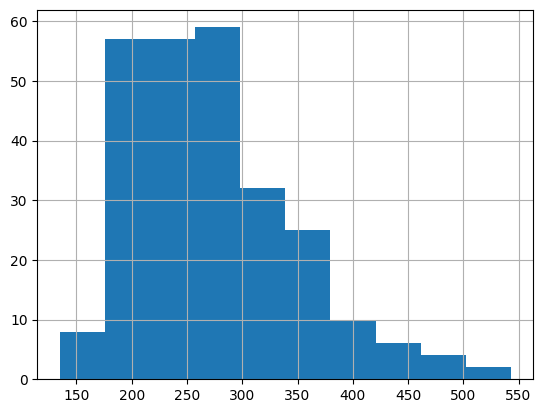

In [21]:
train_data.groupby('unit_number')['time_in_cycles'].max().hist();

The majority of engines complete their operational life within approximately 50–200 cycles.

A smaller subset of engines continue to operate beyond 300 cycles, with the longest lasting over 500 cycles.

This tail of longer-lived engines creates the positive (right) skew in the distribution. 
This pattern indicates that most engines fail or reach the end of their monitored life relatively early, while a smaller number operate significantly longer — a typical characteristic of real-world degradation behavior.
Such variability underscores the importance of robust predictive models that can capture both short- and long-life failure patterns.

****RUL Distribution Analysis****

In [22]:
train_data['RUL'].describe()

count    160359.000000
mean        169.215329
std          95.862031
min           0.000000
25%          97.000000
50%         163.000000
75%         230.000000
max         542.000000
Name: RUL, dtype: float64

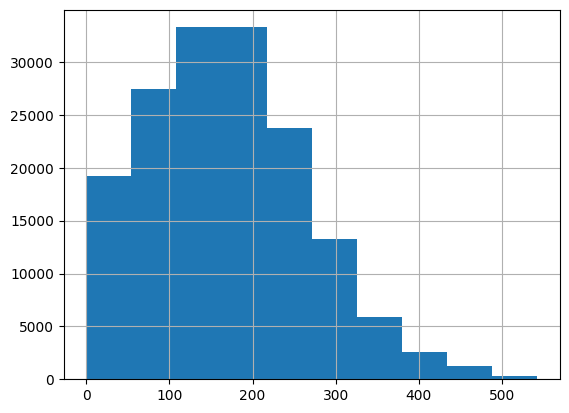

In [23]:
train_data.RUL.hist();

In [24]:
train_data['RUL'].skew()

np.float64(0.5211870954328348)

The histogram of RUL values shows a moderately right-skewed (positively skewed) distribution.

Distribution Shape:
The positive skew (skewness ≈ +0.52) indicates that most records correspond to engines nearing the end of their operational life, while a smaller number represent engines in early, healthy states with higher RUL values (long right tail).

Lifecycle Balance:
The median RUL of 163 cycles suggests that half of all recorded instances occur when engines have less than ~163 cycles remaining.
This concentration near lower RUL values reflects the nature of the training data — it follows each engine from the start of operation until failure, so later degradation stages are naturally more represented.

Operational Implications:
The presence of long-lived engines (maximum RUL ≈ 542 cycles) shows that some engines operate for extended periods before reaching failure conditions, providing a broad range of degradation behaviors for model learning.

Modeling Insight:
The right-skewed RUL distribution implies that predictive models may face class imbalance — more samples at lower RUL values.
To ensure robust learning, normalization or sampling techniques (e.g., weighted loss functions or balanced minibatches) might be beneficial during model training.

****Operating Settings****

In [25]:
train_data[['operating_setting_1', 'operating_setting_2']].describe()

,operating_setting_1,operating_setting_2
count,160359.000000,160359.000000
mean,17.211973,0.410004
std,16.527988,0.367938
min,-0.008700,-0.000600
25%,0.001300,0.000200
50%,19.998100,0.620000
75%,35.001500,0.840000
max,42.008000,0.842000


Wide Operating Range:
Both settings exhibit broad variability, especially operating_setting_1 (range ≈ 0 – 42). This indicates that engines were tested under diverse load or thrust conditions, simulating real-world variability across different mission profiles or flight environments.

Non-Centered Distribution:

operating_setting_1 shows a bimodal or discrete range pattern (near 0 and near 40), consistent with the CMAPSS subsets that switch between two primary operating regimes.

operating_setting_2 has a much narrower range (0 – 0.84) and smaller variance, implying that this parameter captures finer adjustments in engine operation (e.g., secondary environmental or control settings).

Physical Consistency:
Minimum values are close to 0 and no extreme outliers appear, confirming realistic sensor scaling and stable system behavior.

Modeling Implication:
These settings are essential contextual features — they help a predictive model differentiate between normal variation due to operating conditions and true degradation effects.
In practice, models that incorporate operating settings alongside sensor data typically achieve greater generalization across subsets (FD001–FD004).

****Sensor Health Signals****

In [26]:
train_data.iloc[:, train_data.columns.str.contains('sensor_')].describe()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,597.361022,1467.035653,1260.956434,359.729968,2273.829707,8677.553696,44.212049,338.789821,2349.645243,8088.950972,9.054747,360.698801,25.942709,15.565700
std,42.478516,118.175261,136.300073,174.133835,142.426613,374.657454,3.426342,164.193480,111.167242,80.623257,0.751581,31.021430,11.691422,7.015067
min,535.480000,1242.670000,1023.770000,136.170000,1914.720000,7984.510000,36.040000,128.310000,2027.570000,7845.780000,8.156300,302.000000,10.160000,6.010500
25%,549.960000,1357.360000,1126.830000,175.710000,2212.120000,8334.770000,42.010000,164.790000,2387.970000,8070.530000,8.439250,332.000000,14.330000,8.601300
50%,605.930000,1492.810000,1271.740000,341.690000,2319.370000,8764.200000,44.930000,321.690000,2388.070000,8118.590000,9.030100,367.000000,24.920000,14.953500
75%,642.340000,1586.590000,1402.200000,553.290000,2388.050000,9055.850000,47.340000,521.340000,2388.160000,8139.410000,9.344200,392.000000,38.820000,23.294600
max,645.110000,1616.910000,1441.490000,570.810000,2388.640000,9244.590000,48.530000,537.490000,2390.490000,8293.720000,11.066900,400.000000,39.890000,23.950500


The dataset includes multiple onboard sensor measurements that capture different physical aspects of turbofan engine performance — such as pressure, temperature, speed, and fuel flow.
Below is a summarry of the central tendency and variability of the key retained sensors:

Statistic	Key Observations (aggregated across 160,359 records)
Mean values:	Sensor readings vary across broad numeric ranges, reflecting differences in physical units and measurement scales. For instance, sensor_9 (mean ≈ 8678) measures a much larger-magnitude parameter than sensor_11 (mean ≈ 44).

Variability (std):	Standard deviations vary widely — from small fluctuations (sensor_15 std ≈ 0.75) to large variations (sensor_7 std ≈ 174). This confirms that certain sensors are highly dynamic and sensitive to engine condition changes, while others remain relatively stable.

Range (min–max):	Ranges are physically reasonable across all sensors, indicating stable calibration and no extreme outliers. For example, sensor_7 spans roughly 136–571, and sensor_9 spans 7984–9245.

Median alignment:	For most sensors, median values are close to means, suggesting near-symmetric distributions without strong bias.

Interpretation

Healthy Variability Across Sensors:
The dataset captures a wide range of operational behaviors. Sensors such as sensor_3, sensor_4, sensor_7, sensor_8, and sensor_9 show significant variation, suggesting that they are informative indicators of engine performance and degradation.

Stable Sensors:
A few sensors — notably sensor_15, sensor_11, and sensor_21 — show minimal variance, indicating either stable operation or limited sensitivity to degradation.
These may provide context features (baseline operating stability) but are less likely to serve as strong predictors of Remaining Useful Life (RUL) on their own.

No Anomalous Outliers:
Minimum and maximum values fall within expected operational bounds, with no abrupt jumps or invalid readings.
This confirms the data’s reliability and that prior cleaning (constant column removal) was effective.

Distribution Balance:
The absence of extreme skewness across most sensors supports normalizability — allowing safe use of scaling (e.g., MinMax or StandardScaler) in later preprocessing.

Modeling and Analytical Implications

The high-variance sensors (e.g., sensor_3, sensor_4, sensor_7, sensor_9, sensor_12) are prime candidates for feature importance and correlation analysis with RUL.

Low-variance sensors should be monitored for feature redundancy, as they may add little predictive value.

Together, this sensor diversity ensures that the dataset contains rich temporal signals suitable for deep learning or regression-based predictive maintenance modeling.

#### Bivariate Analysis ####

****Sensor vs. RUL relationships****

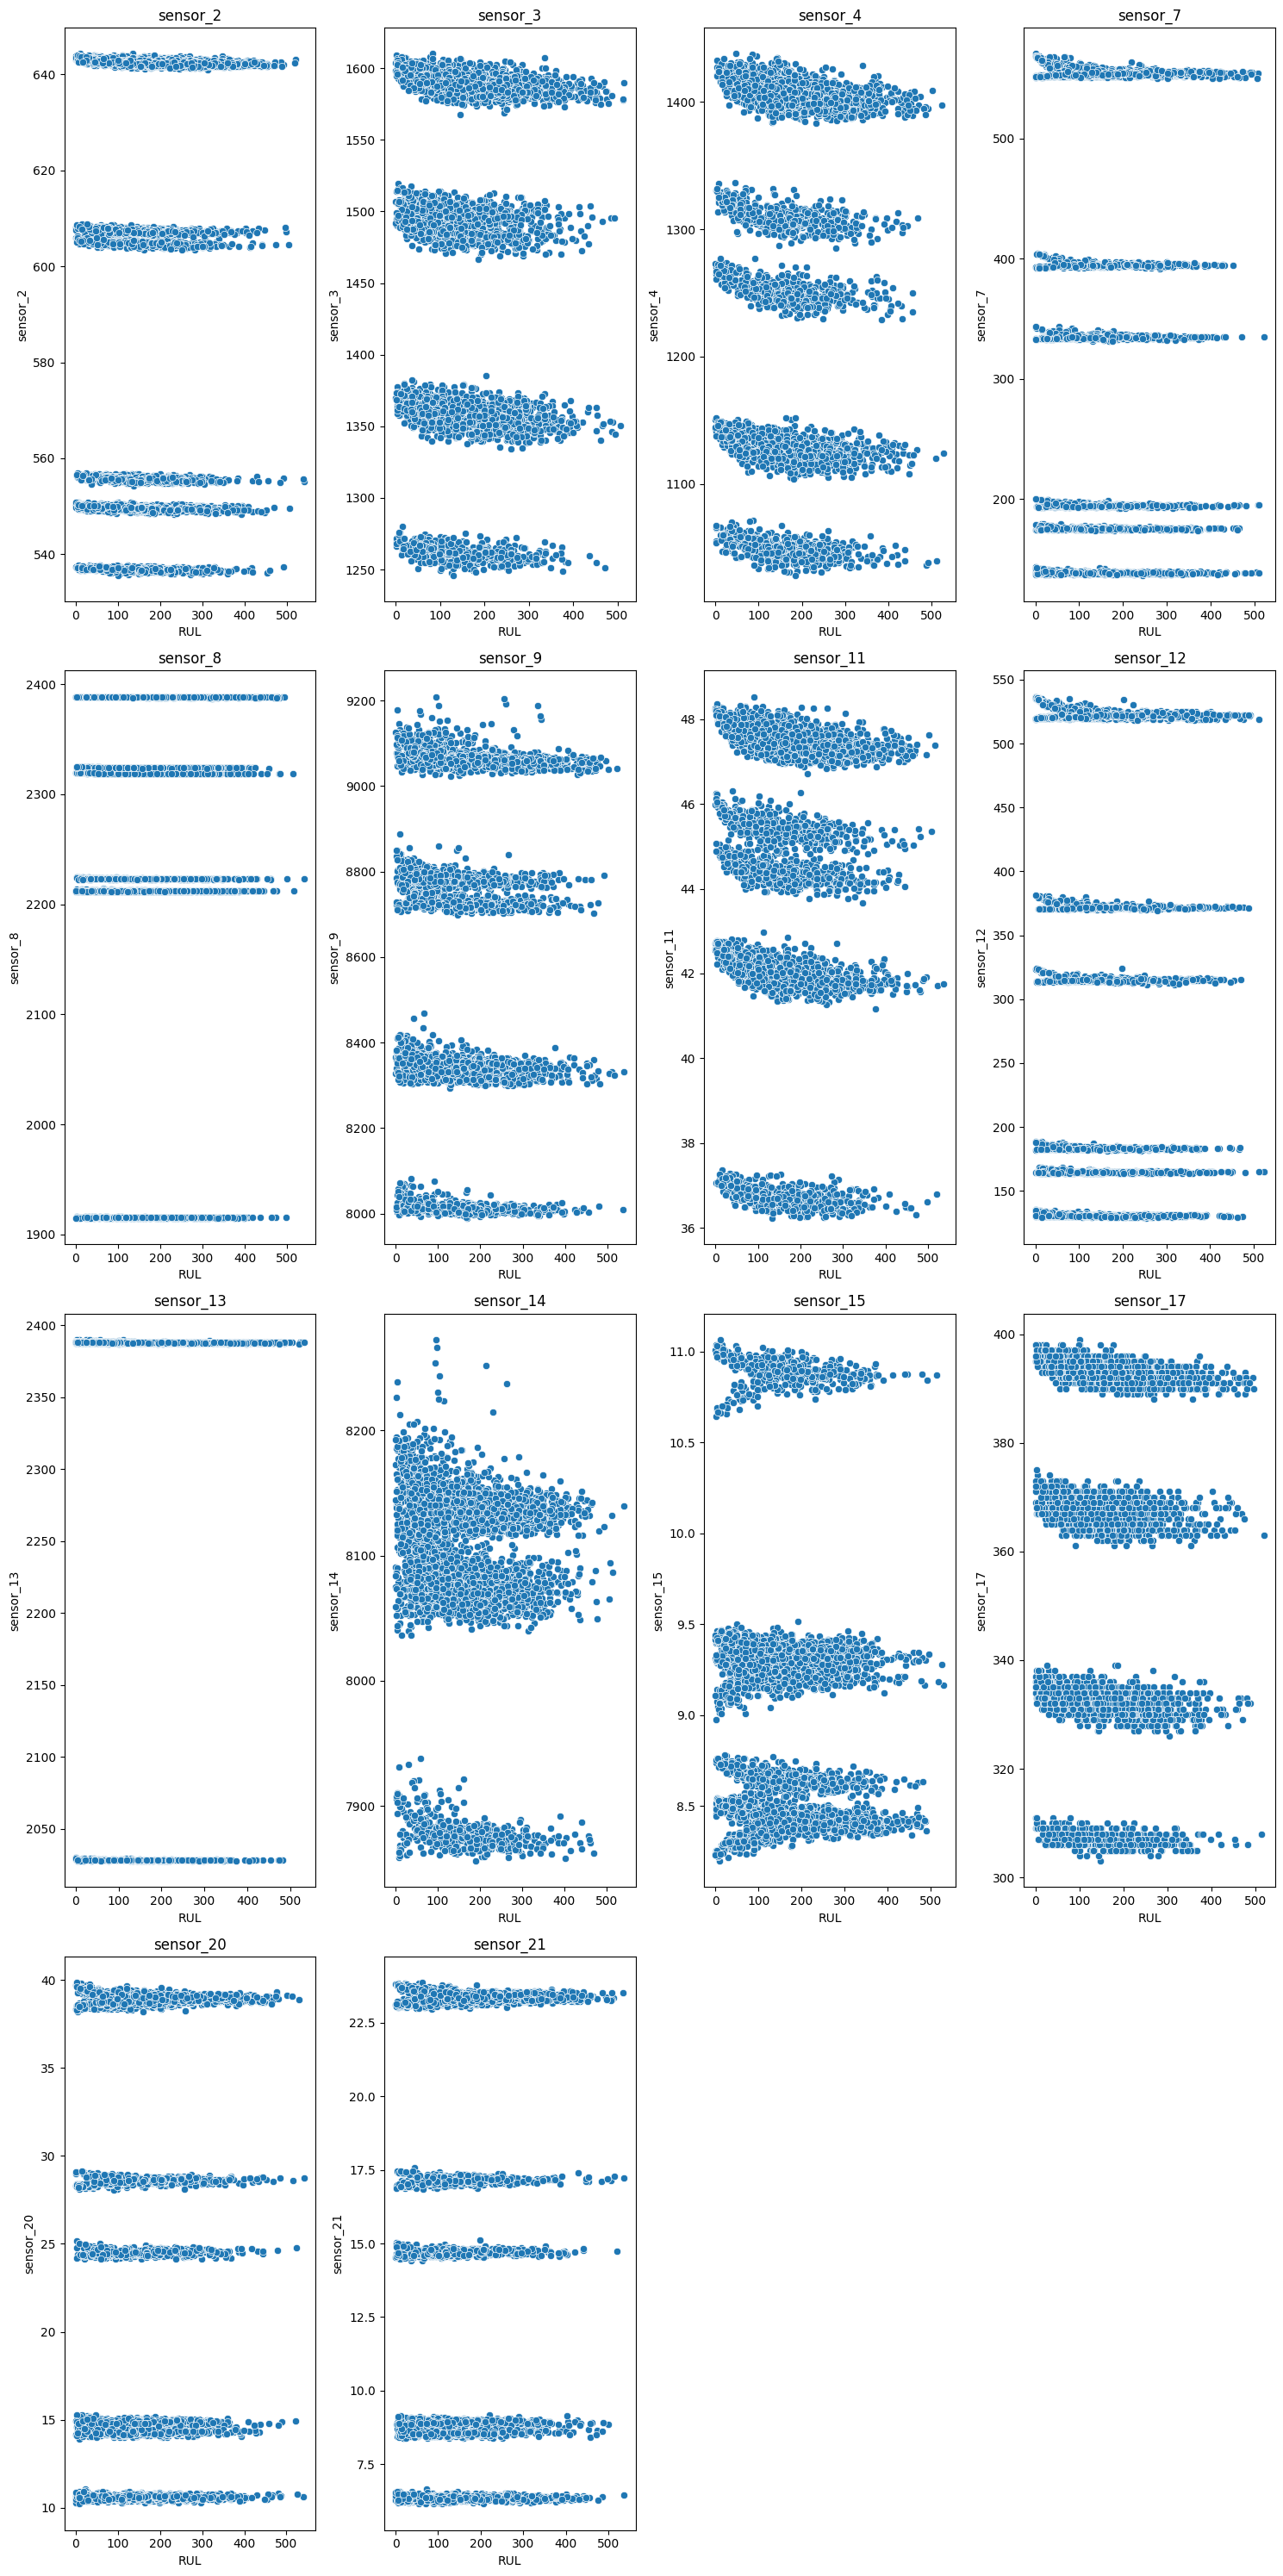

In [27]:
# Plot scatter plots of each sensor against RUL to visually inspect relationships
# This helps identify sensors that may have predictive value for RUL.

# Select only columns containing 'sensor_'
sensor_cols = [col for col in feature_df.columns if 'sensor_' in col]

# Create a 4x4 grid of subplots (adjust rows/cols as needed)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 30))
axes = axes.flatten()  # make it easier to iterate

# Loop through each sensor column and plot
for i, col in enumerate(sensor_cols):
    sns.scatterplot(ax=axes[i], x='RUL', y=feature_df[col], data=feature_df.sample(5000))
    axes[i].set_title(col)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

****Operating settings vs sensors****

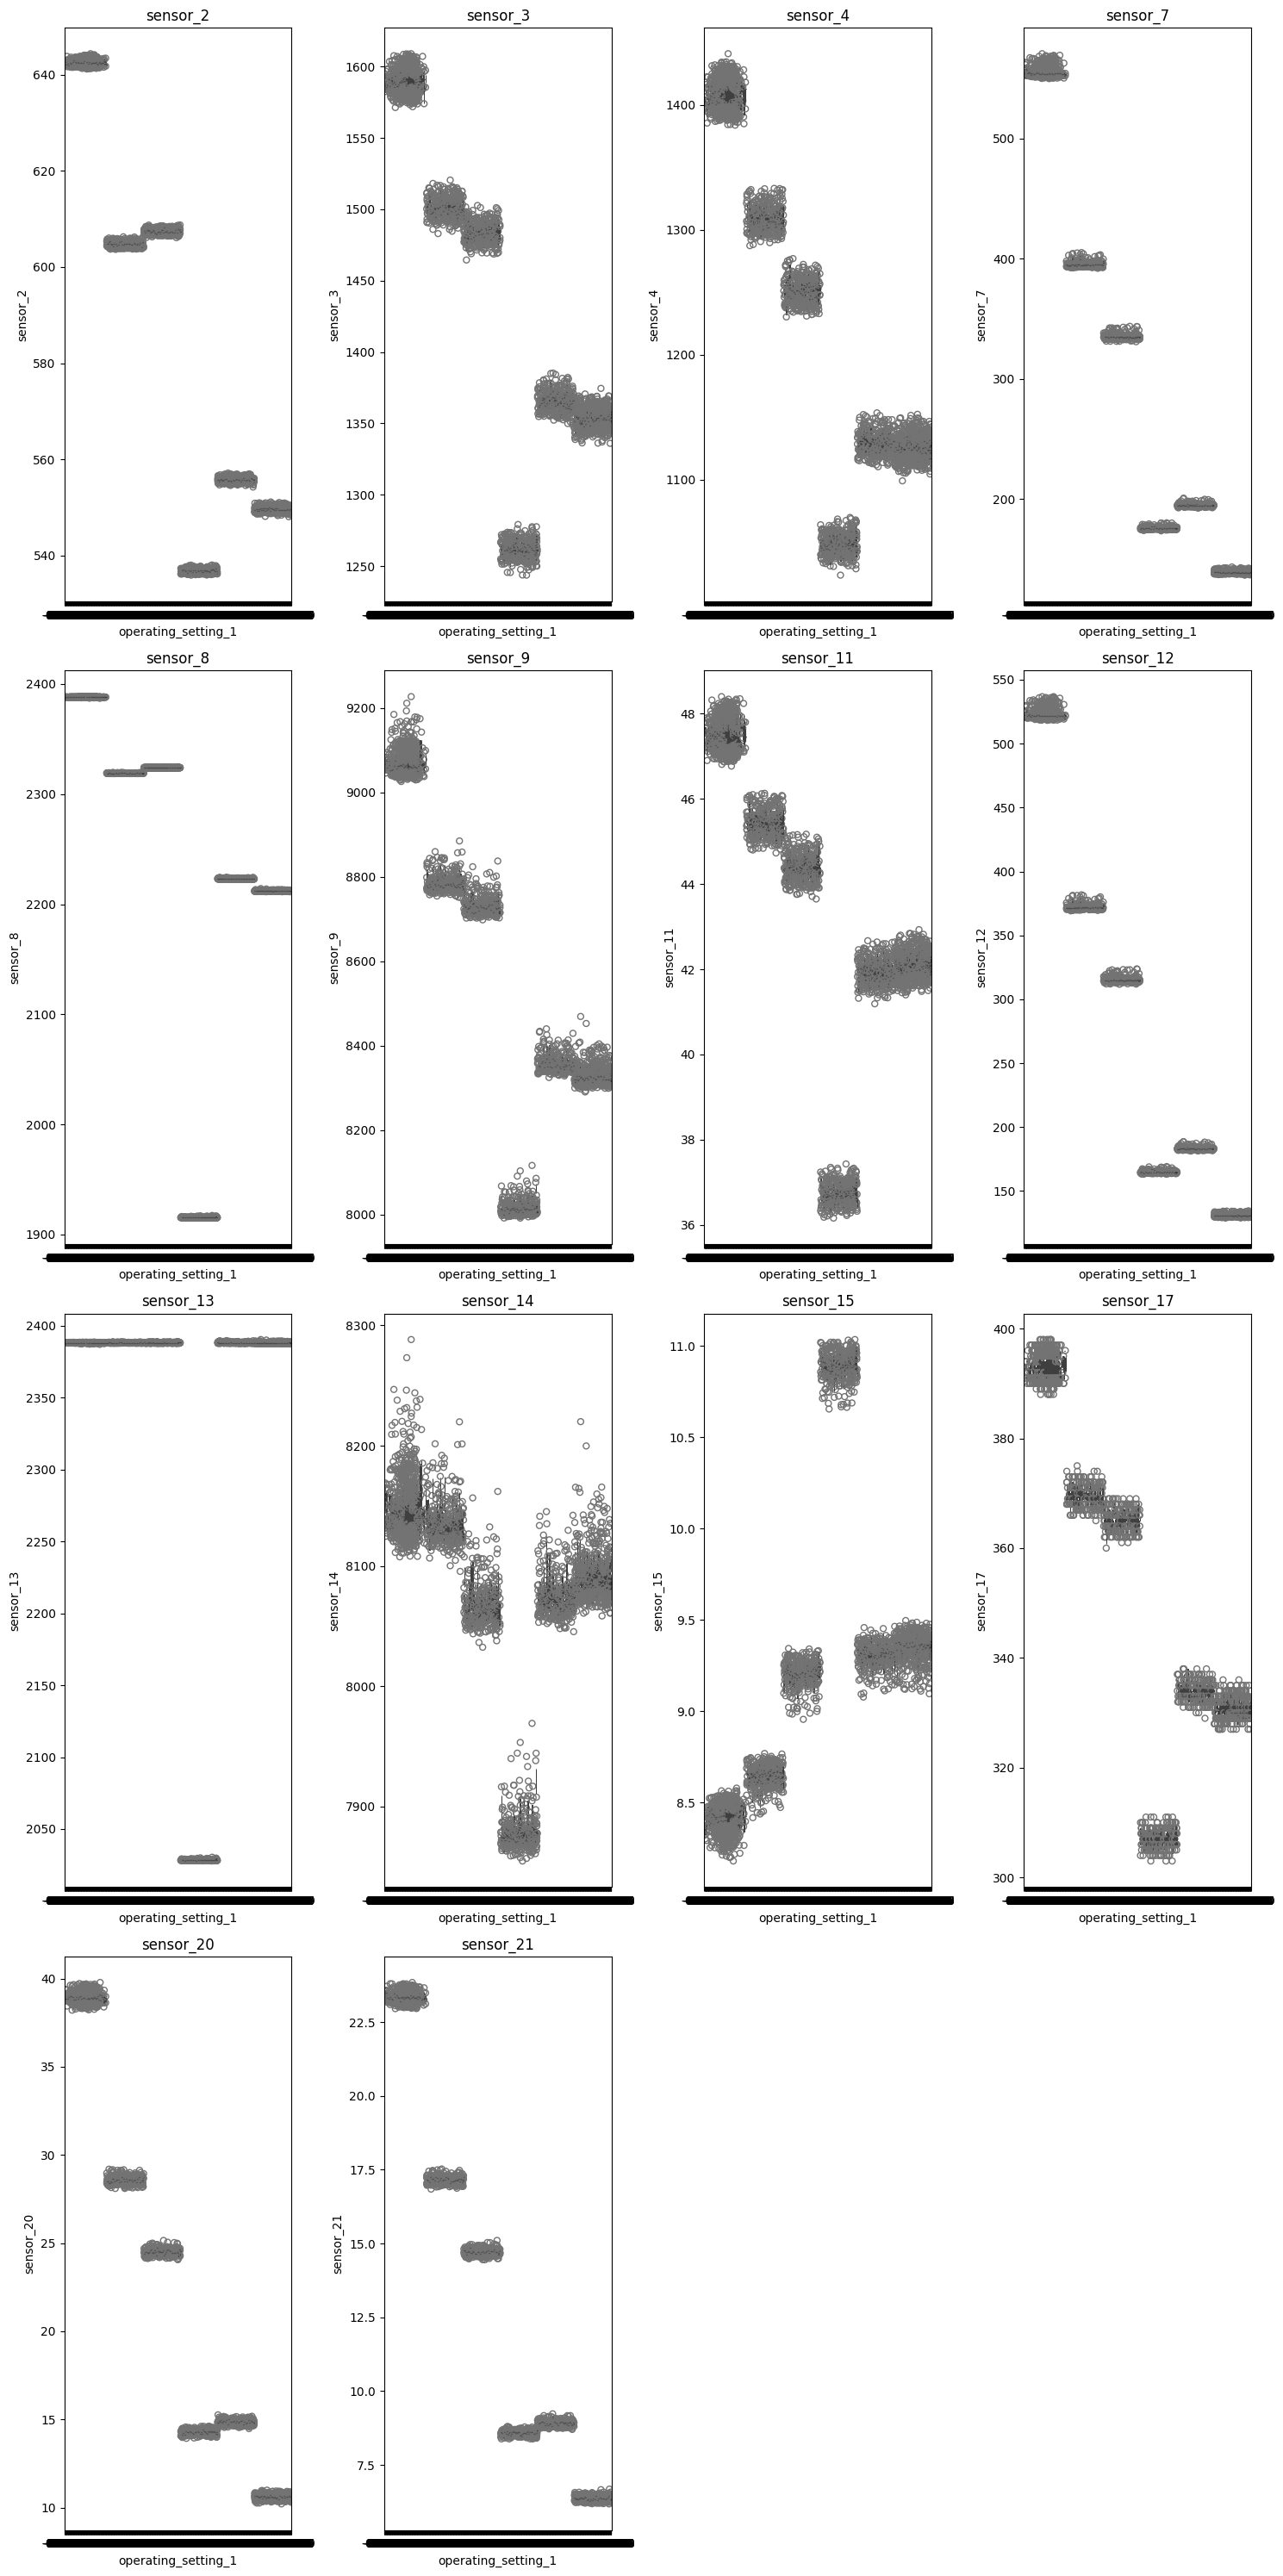

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 30))
axes = axes.flatten()

# Take one sample to reuse across all plots
sample_df = feature_df.sample(5000)

for i, col in enumerate(sensor_cols):
    sns.boxenplot(
        ax=axes[i],
        x='operating_setting_1',
        y=col,                   # column name (string)
        data=sample_df           # sampled data
    )
    axes[i].set_title(col)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


****Time trend per unit****

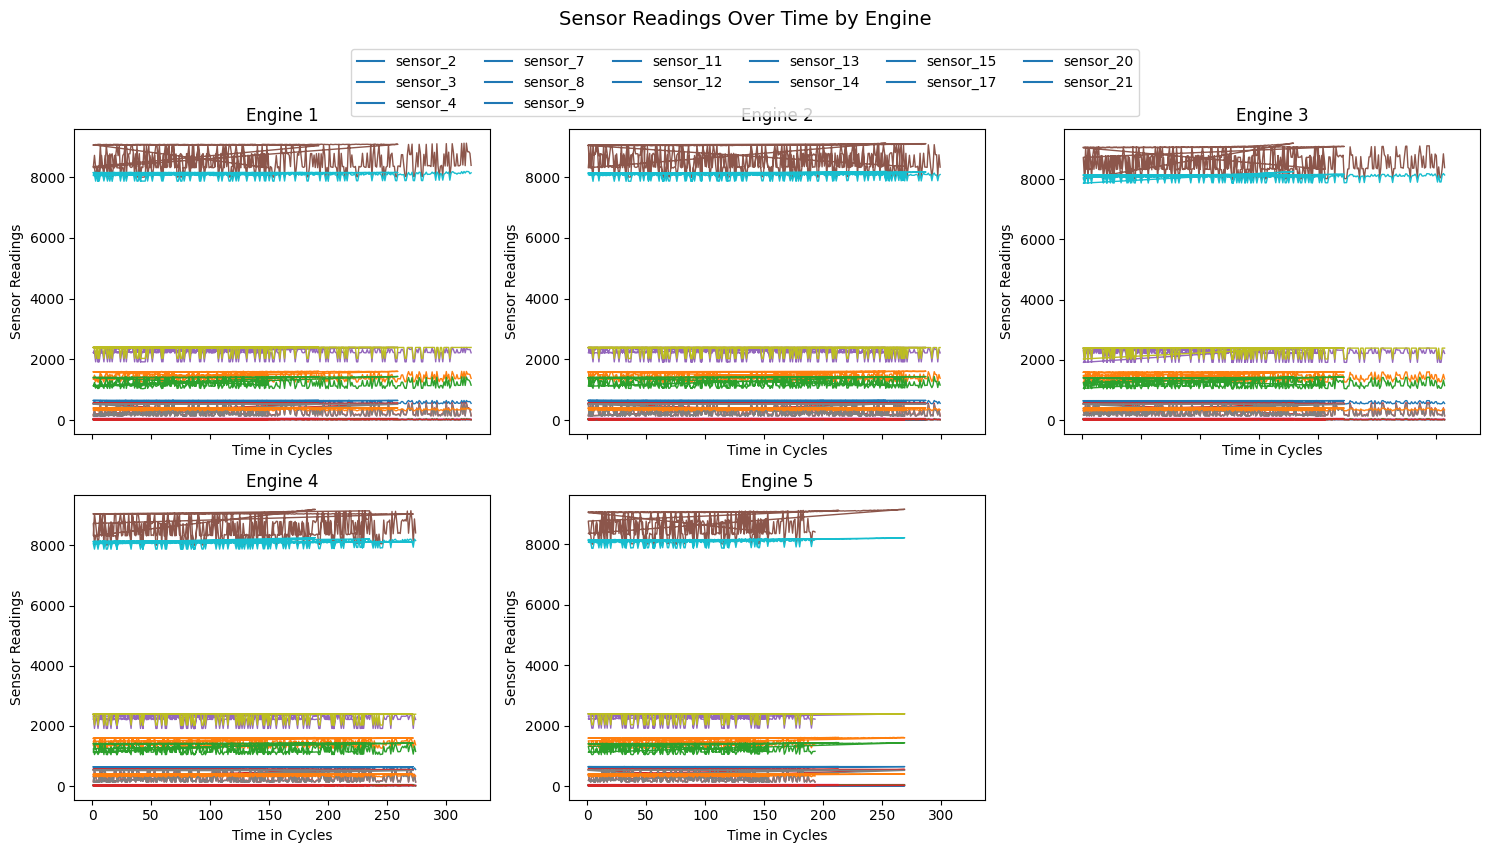

In [29]:
import math


# Pick how many engines to show
units = train_data['unit_number'].unique()[:5]
n_units = len(units)

# Choose a grid (roughly square)
n_cols = math.ceil(math.sqrt(n_units))
n_rows = math.ceil(n_units / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharex=True, sharey=False)
axes = axes.flatten()

# Plot each unit in its own subplot
for ax, unit in zip(axes, units):
    unit_data = train_data[train_data['unit_number'] == unit]
    for sensor in sensor_cols:
        ax.plot(unit_data['time_in_cycles'], unit_data[sensor], linewidth=1)
    ax.set_title(f'Engine {unit}')
    ax.set_xlabel('Time in Cycles')
    ax.set_ylabel('Sensor Readings')

# Remove any unused axes (if grid has extra cells)
for k in range(len(units), len(axes)):
    fig.delaxes(axes[k])

# Single shared legend for all sensors (first axis supplies handles/labels)
handles, labels = axes[0].get_legend_handles_labels()
if not handles:  # build once to avoid duplicate labels
    # build from a dummy plot so we control labels
    handles = [plt.Line2D([0], [0]) for _ in sensor_cols]
    labels = list(sensor_cols)
fig.legend(handles, labels, loc='upper center', ncol=min(len(sensor_cols), 6), bbox_to_anchor=(0.5, 1.02))

fig.suptitle('Sensor Readings Over Time by Engine', y=1.06, fontsize=14)
fig.tight_layout()
plt.show()


****Correlation Matrix****

In [30]:
feature_df.corr()

,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
operating_setting_1,1.000000,0.967487,-0.925472,-0.877521,-0.909480,-0.971758,-0.619974,-0.871095,-0.757426,-0.971526,-0.163065,-0.459088,0.642981,-0.879403,-0.977664,-0.977674,-0.065655
operating_setting_2,0.967487,1.000000,-0.898218,-0.867189,-0.912110,-0.958469,-0.624050,-0.863267,-0.774244,-0.958404,-0.197861,-0.527713,0.686817,-0.869323,-0.959658,-0.959656,-0.070018
sensor_2,-0.925472,-0.898218,1.000000,0.989141,0.988864,0.982334,0.857322,0.987073,0.932675,0.982442,0.493222,0.702645,-0.844254,0.989728,0.979178,0.979172,0.063187
sensor_3,-0.877521,-0.867189,0.989141,1.000000,0.993401,0.958539,0.914962,0.998325,0.973479,0.958803,0.601383,0.792588,-0.907534,0.998944,0.952101,0.952087,0.042124
sensor_4,-0.909480,-0.912110,0.988864,0.993401,1.000000,0.975306,0.877880,0.991848,0.957909,0.975534,0.539443,0.764897,-0.886103,0.993885,0.969753,0.969742,0.035927
sensor_7,-0.971758,-0.958469,0.982334,0.958539,0.975306,1.000000,0.771459,0.955205,0.878567,0.999995,0.365772,0.626133,-0.785956,0.959859,0.999511,0.999511,0.068604
sensor_8,-0.619974,-0.624050,0.857322,0.914962,0.877880,0.771459,1.000000,0.920190,0.973188,0.772068,0.870583,0.931727,-0.976317,0.913329,0.757415,0.757380,0.051520
sensor_9,-0.871095,-0.863267,0.987073,0.998325,0.991848,0.955205,0.920190,1.000000,0.975422,0.955481,0.612060,0.807054,-0.914808,0.998370,0.948457,0.948441,0.045204
sensor_11,-0.757426,-0.774244,0.932675,0.973479,0.957909,0.878567,0.973188,0.975422,1.000000,0.879072,0.754391,0.899750,-0.969625,0.972795,0.866667,0.866641,0.019554
sensor_12,-0.971526,-0.958404,0.982442,0.958803,0.975534,0.999995,0.772068,0.955481,0.879072,1.000000,0.366703,0.626968,-0.786598,0.960121,0.999479,0.999479,0.068447


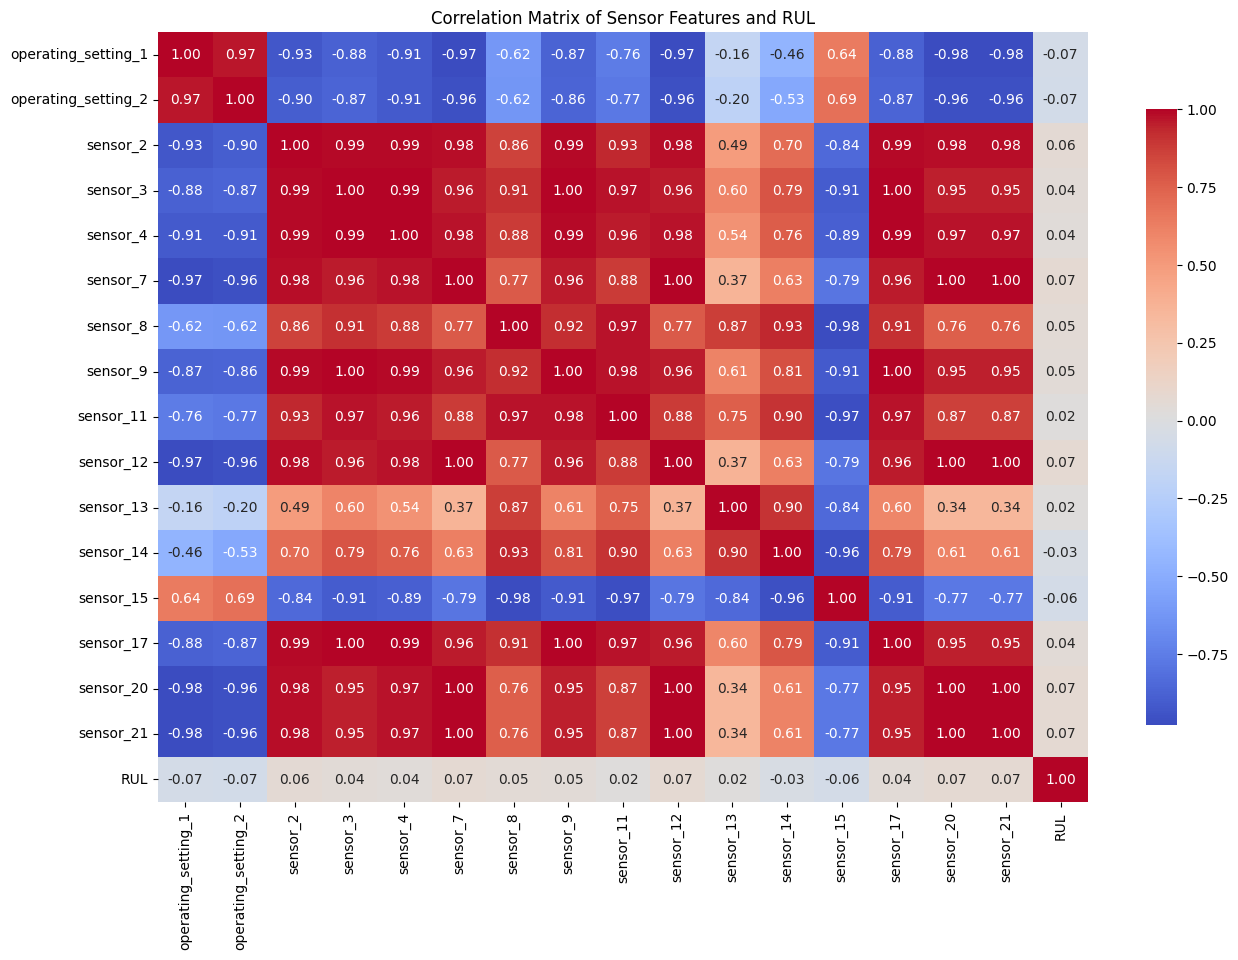

In [31]:
plt.figure(figsize=(15, 10))
sns.heatmap(feature_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Sensor Features and RUL")
plt.show()

This correlation matrix tells us a lot about structure, redundancy, and why naïve linear signals to RUL look weak.

Key takeaways

Operating settings are (almost) one variable

operating_setting_1 ↔ operating_setting_2: r ≈ 0.97 → these two settings are highly collinear and largely encode the same operating regime information.

Both settings are strongly anti-correlated with many sensors (e.g., with sensor_7, sensor_12, sensor_20, sensor_21 r ≈ −0.96 to −0.98), indicating operating regime shifts drive broad sensor level changes.

Massive multicollinearity across sensors

Many sensors move together at very high correlations (r ≥ 0.95–0.999):

Examples:

sensor_3 ↔ sensor_17: 0.999

sensor_7 ↔ sensor_12: ≈ 1.000

sensor_20 ↔ sensor_21: ≈ 1.000

sensor_2/3/4/9/17 are mutually 0.98–0.99

This implies severe redundancy: several channels are effectively duplicates (or linear transforms) under the combined dataset.

Linear correlation with RUL is weak overall

Most |r| with RUL are small (≈ 0.02–0.07). The largest are slightly positive with sensor_20, sensor_21, sensor_7, sensor_12 (≈ 0.07) and slightly negative with sensor_15 (≈ −0.06) and sensor_14 (≈ −0.03).

Interpretation: when we pool all engines and all regimes, operating-condition effects dominate, and degradation is nonlinear/temporal, so global Pearson r to RUL looks muted.

What this means

Regime sensitivity: Sensors shift together with operating settings; any predictive model must distinguish “change due to setting” vs “true degradation.”

Dimensionality reduction is warranted: With near-duplicate sensors, we can safely reduce dimensionality (e.g., PCA) or prune redundant channels without losing information. This simplifies models and improves stability.

Why RUL correlation looks small: RUL evolves over time within each engine and depends on context (operating regime). Global linear correlations average over different trajectories and mask informative trends that appear within engines or within regimes.

In Summary, the dataset suffers from the following core problems:

> Operating-condition confounding (settings drive most sensor variation).

> Temporal nature of degradation (signal is in change over time, not raw levels).

> Severe multicollinearity (many sensors are near-duplicates).

We implement a minimal viable fix as a clean, reusable pipeline. We do it in three steps:

>>Regime-aware normalization (remove operating-condition confounding)

>>Temporal features (turn raw levels into trends/velocities)

>>Redundancy control (drop near-duplicate features)

In [32]:
# Identify some columns
ID_cols = ['unit_number', 'time_in_cycles', 'subset']
Target_col = 'RUL'
All_cols = feature_df.columns.tolist()
Base_feature_cols = All_cols[:-1]  # Exclude target column
Sensor_cols = [col for col in Base_feature_cols if col.startswith('sensor_')]
Setting_cols = [col for col in Base_feature_cols if col.startswith('operating_setting_')]

In [33]:
def fit_subset_normalization(data:pd.DataFrame, feature_cols, subset_col='subset'):
    """
    Fit normalization parameters (mean, std) for each operating regime (subset).
    Returns a dictionary mapping subset to its normalization parameters.
    """
    data = data.copy()
    data[subset_col] = data[subset_col].astype(str).str.strip().str.upper()  # Ensure subset is string and trimmed and uppercase
    normalization_params = {}
    for subset, group in data.groupby(subset_col):
        means = group[feature_cols].mean()
        stds = group[feature_cols].std().replace(0, 1)  # Avoid division by zero
        normalization_params[subset] = (means, stds)
    # ---- GLOBAL fallback ---
    global_means = data[feature_cols].mean()
    global_stds = data[feature_cols].std().replace(0, 1)
    normalization_params['_GLOBAL_'] = (global_means, global_stds)
    return normalization_params

def apply_subset_normalization(data:pd.DataFrame, feature_cols, normalization_params, subset_col='subset', suffix='_zn'):
    """
    Apply normalization to the data using precomputed parameters. Apply pre-fit per-subset (mean, std). Appends normalized columns with suffix.
    Missing subsets (not seen in train) are left unnormalized (columns will be NaN-free due to no assignment).

    """
    out = data.copy()
    out[subset_col] = out[subset_col].astype(str).str.strip().str.upper()  # Ensure subset is string and trimmed and uppercase
    # Pre-create normalized columns for all rows (avoid partial assignment NaNs)
    zn_cols = [f + suffix for f in feature_cols]
    out[zn_cols] = np.nan  # Initialize with NaNs

    for subset, (means, stds) in normalization_params.items():
        mask = out[subset_col] == subset
        if not mask.any():
            continue
            # Align stats to columns explicitly
        m = means.reindex(feature_cols).astype(float)
        s = stds.reindex(feature_cols).astype(float).replace(0, 1.0).fillna(1.0)  # Avoid division by zero
        #Pull numeric block for this subset as ndarray
        #X = out.loc[mask, feature_cols].astype(float).to_numpy()
        # Compute normalized block as ndarray
        #Z = (X - m.to_numpy()) / s.to_numpy()
        # Assign back to DataFrame
        #assert Z.shape == (mask.sum(), len(feature_cols))
        #out.loc[mask, zn_cols] = Z
        ## *** key fix: assign by values so columns don't need to match ***
        #vals = (out.loc[mask, feature_cols] - m) / s
        # Compute normalized block, then set column names to match destination
        norm_block = ((out.loc[mask, feature_cols] - m) / s).add_suffix(suffix)
        # Ensure columns are in the same order as zn_cols
        norm_block = norm_block[zn_cols]
        #norm_block = norm_block.set_axis(zn_cols, axis=1, inplace=False)

        out.loc[mask, zn_cols] = norm_block
    # Optional: warn if there are subsets not in norms (would leave NaNs)
    known_subsets = set(normalization_params.keys())
    known_subsets.discard('_GLOBAL_')  # Exclude global fallback from known subsets
    missing_mask = ~out[subset_col].isin(known_subsets)
    if missing_mask.any() and '_GLOBAL_' in normalization_params:
        m,s = normalization_params['_GLOBAL_']
        m = m.reindex(feature_cols).astype(float)
        s = s.reindex(feature_cols).astype(float).replace(0, 1.0).fillna(1.0)
        norm_block = ((out.loc[missing_mask, feature_cols] - m) / s).add_suffix(suffix)
        norm_block = norm_block[zn_cols]
        out.loc[missing_mask, zn_cols] = norm_block
        print(f"Applied global normalization to {missing_mask.sum()} rows with unknown subsets.")
    missing_subsets = set(out[subset_col].unique()) - set(normalization_params.keys())
    if missing_subsets:
        print(f"Warning: Subsets {missing_subsets} not in normalization parameters; their normalized columns will be NaN.")
    return out

# Fit normalization parameters on training data
norm_cols = Base_feature_cols
subset_norms =fit_subset_normalization(train_data, norm_cols, subset_col='subset')
# Apply normalization to both train and test data
train_norm = apply_subset_normalization(train_data, norm_cols, subset_norms, subset_col='subset', suffix='_zn')
test_norm = apply_subset_normalization(test_data, norm_cols, subset_norms, subset_col='subset', suffix='_zn')


In [34]:
"""
Temporal features (within engine)

We create first differences, rolling mean/STD, 
and a rolling slope (linear trend) over short windows — per engine and using the normalized features.
"""
def add_temporal_features(data:pd.DataFrame, base_cols, unit_col = 'unit_number', time_col ='time_in_cycles', window=(5, 20),
                          add_diff=True, add_roll_mean=True, add_roll_std=True, add_roll_slope=True, suffix_in = 'zn'):
    """
    Add temporal features: first differences, rolling mean, rolling std, and rolling slope (trend) per engine unit.
    """
    data = data.sort_values(by=[unit_col, time_col]).copy()
    #prefer normalized features if available
    zn_cols = [c for c in base_cols if c.endswith(suffix_in)]
    use_cols = zn_cols if zn_cols else base_cols
    # Fail fast if inputs are all NaN
    if not use_cols or data[use_cols].isna().all().all():
        print("Warning: No valid columns found for temporal feature engineering. Returning original data.")
        raise ValueError("No valid columns for temporal feature engineering. All input columns are NaN.")
    def rolling_slope(s, w):
        #slope of y on t(0...w-1) using closed-form OLS
        t = np.arange(w, dtype= float)
        y = s.values
        ybar = y.mean()
        tbar = (w - 1) / 2.0
        denom = w * (w**2 - 1) / 12.0
        numer = (t * y).sum() - w * tbar * ybar
        return numer / denom if denom != 0 else 0.0
    
    g = data.groupby(unit_col, group_keys= False)
    # --- accumulate new columns here ---
    new_cols = {}
    #first differences
    if add_diff:
        for col in use_cols:
            base = col.replace(suffix_in, '')
            new_cols[base + '_diff'] = g[col].diff().fillna(0.0)
    #rolling stats/slope
    for w in window:
        if add_roll_mean:
            for col in use_cols:
                base = col.replace(suffix_in, '')
                new_cols[f'{base}_rmean{w}'] = g[col].rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
        if add_roll_std:
            for col in use_cols:
                base = col.replace(suffix_in, '')
                new_cols[f'{base}_rstd{w}'] = g[col].rolling(window=w, min_periods=2).std().fillna(0.0).reset_index(level=0, drop=True)
    if add_roll_slope:
        # DEBUG: make sure you actually have many columns here
        print("add_roll_slope: len(use_cols) =", len(use_cols), "sample:", use_cols[:5])
        for w in window:    
            for col in use_cols:
                base = col.replace(suffix_in, '')
                new_cols[f'{base}_rslope{w}'] = g[col].rolling(window=w, min_periods=w).apply(lambda s: rolling_slope(s, w), raw=False).fillna(0.0).reset_index(level=0, drop=True)
                # validity flag: 1 when we actually had w points, else 0
                new_cols[f'{base}_rslope{w}_valid'] = (g[col].rolling(window=w).count().reset_index(level=0, drop=True).ge(w)).astype('int8')
        #Confirm your use_cols matches what you intended. 
        # With the debug print added above you’ll see len(use_cols) in the logs at run time.
        # Ensure the _valid line is inside the same inner loop as the slope line (exact same indentation). 
        # If it’s outside, you’ll only get the last column’s _valid.
        expected_valid = len(use_cols) * len(window)
        actual_valid = sum(1 for k in new_cols if k.endswith('_valid'))
        print(f"rslope_valid created: {actual_valid} / expected: {expected_valid}")
        if actual_valid != expected_valid:
            print(f"Warning: Expected {expected_valid} _valid columns but found {actual_valid}. Check indentation of _valid line.")
        # Concatenate once to avoid fragmentation
    if new_cols:
        data = pd.concat([data, pd.DataFrame(new_cols, index=data.index)], axis=1)
    # Optional: defragment copy (pandas hint in the warning)
    data = data.copy()


    return data

# Build temporal features from normalized SENSORS (primary degradation signals)
norm_sensor_cols = [col + '_zn' for col in Sensor_cols]
train_feat = add_temporal_features(train_norm, norm_sensor_cols, window=(5, 20), suffix_in='_zn')
test_feat = add_temporal_features(test_norm, norm_sensor_cols, window=(5, 20), suffix_in='_zn')

add_roll_slope: len(use_cols) = 14 sample: ['sensor_2_zn', 'sensor_3_zn', 'sensor_4_zn', 'sensor_7_zn', 'sensor_8_zn']
rslope_valid created: 28 / expected: 28
add_roll_slope: len(use_cols) = 14 sample: ['sensor_2_zn', 'sensor_3_zn', 'sensor_4_zn', 'sensor_7_zn', 'sensor_8_zn']
rslope_valid created: 28 / expected: 28


In [35]:
try:
    print("len(SENSOR_COLS) =", len(SENSOR_COLS))
except NameError:
    print("SENSOR_COLS not defined")

try:
    print("len(Sensor_cols) =", len(Sensor_cols))
except NameError:
    print("Sensor_cols not defined")

SENSOR_COLS not defined
len(Sensor_cols) = 14


In [36]:
norm_sensor_cols = [c + '_zn' for c in (Sensor_cols if 'Sensor_cols' in globals() else SENSOR_COLS)]
missing = [c for c in norm_sensor_cols if c not in train_norm.columns]
print("Missing *_zn columns:", missing[:10], " ... count:", len(missing))

Missing *_zn columns: []  ... count: 0


In [37]:
existing = [c for c in norm_sensor_cols if c in train_norm.columns]
print("Total NaNs in existing *_zn:", train_norm[existing].isna().sum().sum())

Total NaNs in existing *_zn: 0


In [38]:
# 3) Do the subsets match those used to fit norms?
print("subsets in train_norm:", sorted(train_norm['subset'].unique()))
print("subsets in norms:", sorted(list(subset_norms.keys())))

subsets in train_norm: ['FD001', 'FD002', 'FD003', 'FD004']
subsets in norms: ['FD001', 'FD002', 'FD003', 'FD004', '_GLOBAL_']


In [39]:
# Redundancy control (drop highly correlated features)
# We’ll remove one feature from any pair with |r| ≥ 0.995. 
# We’ll fit the selection on train and apply the same column selection to test.
def drop_highly_correlated_features(data:pd.DataFrame, threshold=0.995, 
                                    protect = ID_cols + [Target_col, 'subset'], verbose=True):
    """
    Drop one feature from any pair with |r| ≥ threshold.
    Returns the list of selected (kept) features.
    """
    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [col for col in num_cols if col not in protect]
    corr_matrix = data[num_cols].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= threshold)]
    selected_cols = [col for col in num_cols if col not in to_drop]
    if verbose:
        print(f"Dropping {len(to_drop)} highly correlated features:(|r| >= {threshold}).")
    return  selected_cols, to_drop
# Fit feature selection on TRAIN ONLY
selected_features, dropped_features = drop_highly_correlated_features(train_feat, threshold=0.995, verbose=True)
# Build final datasets with selected features
Model_feature_cols = selected_features + [Target_col] # Always include target for training
train_model = train_feat[ID_cols + Model_feature_cols].copy()
test_model  = test_feat[ID_cols + [c for c in selected_features if c != Target_col] + [Target_col] if Target_col in test_feat.columns else ID_cols + selected_features].copy()


Dropping 31 highly correlated features:(|r| >= 0.995).


In [40]:
train_model[:4]

,unit_number,time_in_cycles,subset,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_13,sensor_14,sensor_15,operating_setting_1_zn,operating_setting_2_zn,sensor_2_zn,sensor_3_zn,sensor_4_zn,sensor_7_zn,sensor_8_zn,sensor_9_zn,sensor_11_zn,sensor_12_zn,sensor_13_zn,sensor_14_zn,sensor_15_zn,sensor_17_zn,sensor_20_zn,sensor_21_zn,sensor_2_diff,sensor_3_diff,sensor_4_diff,sensor_7_diff,sensor_8_diff,sensor_9_diff,sensor_11_diff,sensor_12_diff,sensor_13_diff,sensor_14_diff,sensor_15_diff,sensor_17_diff,sensor_20_diff,sensor_21_diff,sensor_2_rmean5,sensor_3_rmean5,sensor_4_rmean5,sensor_7_rmean5,sensor_8_rmean5,sensor_9_rmean5,sensor_11_rmean5,sensor_12_rmean5,sensor_13_rmean5,sensor_14_rmean5,sensor_15_rmean5,sensor_17_rmean5,sensor_20_rmean5,sensor_21_rmean5,sensor_2_rstd5,sensor_3_rstd5,sensor_4_rstd5,sensor_7_rstd5,sensor_8_rstd5,sensor_9_rstd5,sensor_11_rstd5,sensor_12_rstd5,sensor_13_rstd5,sensor_14_rstd5,sensor_15_rstd5,sensor_17_rstd5,sensor_20_rstd5,sensor_21_rstd5,sensor_2_rmean20,sensor_3_rmean20,sensor_4_rmean20,sensor_7_rmean20,sensor_8_rmean20,sensor_9_rmean20,sensor_11_rmean20,sensor_12_rmean20,sensor_13_rmean20,sensor_14_rmean20,sensor_15_rmean20,sensor_17_rmean20,sensor_20_rmean20,sensor_21_rmean20,sensor_2_rstd20,sensor_3_rstd20,sensor_4_rstd20,sensor_7_rstd20,sensor_8_rstd20,sensor_9_rstd20,sensor_11_rstd20,sensor_12_rstd20,sensor_13_rstd20,sensor_14_rstd20,sensor_15_rstd20,sensor_17_rstd20,sensor_20_rstd20,sensor_21_rstd20,sensor_2_rslope5,sensor_2_rslope5_valid,sensor_3_rslope5,sensor_4_rslope5,sensor_7_rslope5,sensor_8_rslope5,sensor_9_rslope5,sensor_11_rslope5,sensor_12_rslope5,sensor_13_rslope5,sensor_14_rslope5,sensor_15_rslope5,sensor_17_rslope5,sensor_20_rslope5,sensor_21_rslope5,sensor_2_rslope20,sensor_2_rslope20_valid,sensor_3_rslope20,sensor_4_rslope20,sensor_7_rslope20,sensor_8_rslope20,sensor_9_rslope20,sensor_11_rslope20,sensor_12_rslope20,sensor_13_rslope20,sensor_14_rslope20,sensor_15_rslope20,sensor_17_rslope20,sensor_20_rslope20,sensor_21_rslope20,RUL
0,1,1,FD001,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,47.47,2388.02,8138.62,8.4195,-0.315972,-1.372920,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
20631,1,1,FD002,34.9983,0.8400,555.32,1358.61,1137.23,194.64,2222.65,42.02,2387.72,8048.56,9.3461,0.745888,0.864290,-0.653065,-0.579171,-0.572616,-0.602490,-0.042898,-0.545814,-0.298596,-0.603003,0.415113,-0.212613,0.021948,-0.515574,-0.613952,-0.619142,1.068619,-0.444919,0.353297,-1.723604,0.473428,0.316979,-0.032136,-0.937256,1.473977,0.056451,0.625749,0.266117,-1.962412,-1.813540,-1.187374,-0.356711,-0.749265,0.259312,-0.279612,-0.704303,-0.282528,-0.134374,-0.321876,-0.240839,-0.290927,-0.648633,0.367254,0.287628,0.755628,0.314605,0.249819,1.218772,0.334764,0.224138,0.022723,0.662740,1.042259,0.039917,0.442471,0.188173,1.387635,1.282367,-1.187374,-0.356711,-0.749265,0.259312,-0.279612,-0.704303,-0.282528,-0.134374,-0.321876,-0.240839,-0.290927,-0.648633,0.367254,0.287628,0.755628,0.314605,0.249819,1.218772,0.334764,0.224138,0.022723,0.662740,1.042259,0.039917,0.442471,0.188173,1.387635,1.282

In [41]:
train_model[10000:10005]

,unit_number,time_in_cycles,subset,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_13,sensor_14,sensor_15,operating_setting_1_zn,operating_setting_2_zn,sensor_2_zn,sensor_3_zn,sensor_4_zn,sensor_7_zn,sensor_8_zn,sensor_9_zn,sensor_11_zn,sensor_12_zn,sensor_13_zn,sensor_14_zn,sensor_15_zn,sensor_17_zn,sensor_20_zn,sensor_21_zn,sensor_2_diff,sensor_3_diff,sensor_4_diff,sensor_7_diff,sensor_8_diff,sensor_9_diff,sensor_11_diff,sensor_12_diff,sensor_13_diff,sensor_14_diff,sensor_15_diff,sensor_17_diff,sensor_20_diff,sensor_21_diff,sensor_2_rmean5,sensor_3_rmean5,sensor_4_rmean5,sensor_7_rmean5,sensor_8_rmean5,sensor_9_rmean5,sensor_11_rmean5,sensor_12_rmean5,sensor_13_rmean5,sensor_14_rmean5,sensor_15_rmean5,sensor_17_rmean5,sensor_20_rmean5,sensor_21_rmean5,sensor_2_rstd5,sensor_3_rstd5,sensor_4_rstd5,sensor_7_rstd5,sensor_8_rstd5,sensor_9_rstd5,sensor_11_rstd5,sensor_12_rstd5,sensor_13_rstd5,sensor_14_rstd5,sensor_15_rstd5,sensor_17_rstd5,sensor_20_rstd5,sensor_21_rstd5,sensor_2_rmean20,sensor_3_rmean20,sensor_4_rmean20,sensor_7_rmean20,sensor_8_rmean20,sensor_9_rmean20,sensor_11_rmean20,sensor_12_rmean20,sensor_13_rmean20,sensor_14_rmean20,sensor_15_rmean20,sensor_17_rmean20,sensor_20_rmean20,sensor_21_rmean20,sensor_2_rstd20,sensor_3_rstd20,sensor_4_rstd20,sensor_7_rstd20,sensor_8_rstd20,sensor_9_rstd20,sensor_11_rstd20,sensor_12_rstd20,sensor_13_rstd20,sensor_14_rstd20,sensor_15_rstd20,sensor_17_rstd20,sensor_20_rstd20,sensor_21_rstd20,sensor_2_rslope5,sensor_2_rslope5_valid,sensor_3_rslope5,sensor_4_rslope5,sensor_7_rslope5,sensor_8_rslope5,sensor_9_rslope5,sensor_11_rslope5,sensor_12_rslope5,sensor_13_rslope5,sensor_14_rslope5,sensor_15_rslope5,sensor_17_rslope5,sensor_20_rslope5,sensor_21_rslope5,sensor_2_rslope20,sensor_2_rslope20_valid,sensor_3_rslope20,sensor_4_rslope20,sensor_7_rslope20,sensor_8_rslope20,sensor_9_rslope20,sensor_11_rslope20,sensor_12_rslope20,sensor_13_rslope20,sensor_14_rslope20,sensor_15_rslope20,sensor_17_rslope20,sensor_20_rslope20,sensor_21_rslope20,RUL
22534,11,8,FD002,35.0005,0.8400,555.33,1358.36,1123.59,195.15,2223.04,41.74,2388.11,8071.49,9.3110,0.746037,0.864290,-0.652797,-0.581530,-0.687119,-0.598997,-0.040212,-0.516273,-0.385219,-0.598426,0.418158,0.057667,-0.024893,-0.515574,-0.599767,-0.577110,0.288970,0.024085,0.212129,-1.833093,0.757862,0.128703,1.566083,-2.302072,1.059886,0.228703,0.973521,0.911793,-2.612140,-1.799221,-0.928729,-0.698845,-0.888988,-0.351419,-0.390334,-0.656005,-0.841917,-0.270987,-0.031460,-0.218936,-0.201152,-0.797318,0.044325,-0.317159,0.405855,0.236045,0.304532,0.900748,0.449587,0.196293,0.740285,1.116909,0.616979,0.551842,0.453428,0.381793,1.228762,0.880489,-0.393141,-0.531609,-0.528750,0.142272,-0.321120,-0.297087,-0.558262,0.182832,-0.198117,-0.124621,-0.540123,-0.450745,0.325228,0.193765,0.913126,1.013658,0.984946,1.030739,0.754670,0.799393,0.972021,1.110717,0.656380,0.602916,0.621113,0.919008,0.979723,1.018937,0.065300,1,0.040967,0.059216,0.204483,0.015927,0.039750,-0.064976,0.258100,0.012758,0.096867,-0.087411,-0.046596,0.156455,0.187155,-0.035633,1,0.024275,-0.011439,-0.011156,-0.002044,-0.013173,-0.020006,0.002879,0.014520,0.006322,0.012481,-0.018057,0.001104,-0.002485,293
77472,11,8,FD003,0.0010,0.0005,641.55,1581.67,1395.16,552.03,2387.92,47.06,2387.93,8135.91,8.4157,0.466707,1.683194,-1.735763,-0.941084,-0.952731,-0.905876,-0.957480,-0.729759,-1.185396,-0.746740,-0.895792,-0.502476,0.322652,-0.889346,-0.315641,-0.164333,-1.082966,-0.359554,-0.265612,-0.306879,-0.917268,-0.213486,-0.800177,-0.148314,-1.313950,-0.560142,0.347546,-0.373771,0.284126,0.412777,-1.147950,-0.780516,-0.934286,-0.411836,-0.573802,-0.694056,-0.997002,-0.300490,-0.294250,-0.335467,-0.126278,-0.864866,0.101150,-0.230521,0.496570,0.234843,0.290807,0.931513,0.458048,0.186247,0.707678,1.129623,0.656177,0.534122,0.511468,0.356491,1.197706,0.867217,-0.475354,-0.498131,-0.522559,0.124962,-0.317962,-0.285500,-0.574925,0.175305,-0.207603,-

In [42]:
train_model[54000:54005]

,unit_number,time_in_cycles,subset,operating_setting_1,operating_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_13,sensor_14,sensor_15,operating_setting_1_zn,operating_setting_2_zn,sensor_2_zn,sensor_3_zn,sensor_4_zn,sensor_7_zn,sensor_8_zn,sensor_9_zn,sensor_11_zn,sensor_12_zn,sensor_13_zn,sensor_14_zn,sensor_15_zn,sensor_17_zn,sensor_20_zn,sensor_21_zn,sensor_2_diff,sensor_3_diff,sensor_4_diff,sensor_7_diff,sensor_8_diff,sensor_9_diff,sensor_11_diff,sensor_12_diff,sensor_13_diff,sensor_14_diff,sensor_15_diff,sensor_17_diff,sensor_20_diff,sensor_21_diff,sensor_2_rmean5,sensor_3_rmean5,sensor_4_rmean5,sensor_7_rmean5,sensor_8_rmean5,sensor_9_rmean5,sensor_11_rmean5,sensor_12_rmean5,sensor_13_rmean5,sensor_14_rmean5,sensor_15_rmean5,sensor_17_rmean5,sensor_20_rmean5,sensor_21_rmean5,sensor_2_rstd5,sensor_3_rstd5,sensor_4_rstd5,sensor_7_rstd5,sensor_8_rstd5,sensor_9_rstd5,sensor_11_rstd5,sensor_12_rstd5,sensor_13_rstd5,sensor_14_rstd5,sensor_15_rstd5,sensor_17_rstd5,sensor_20_rstd5,sensor_21_rstd5,sensor_2_rmean20,sensor_3_rmean20,sensor_4_rmean20,sensor_7_rmean20,sensor_8_rmean20,sensor_9_rmean20,sensor_11_rmean20,sensor_12_rmean20,sensor_13_rmean20,sensor_14_rmean20,sensor_15_rmean20,sensor_17_rmean20,sensor_20_rmean20,sensor_21_rmean20,sensor_2_rstd20,sensor_3_rstd20,sensor_4_rstd20,sensor_7_rstd20,sensor_8_rstd20,sensor_9_rstd20,sensor_11_rstd20,sensor_12_rstd20,sensor_13_rstd20,sensor_14_rstd20,sensor_15_rstd20,sensor_17_rstd20,sensor_20_rstd20,sensor_21_rstd20,sensor_2_rslope5,sensor_2_rslope5_valid,sensor_3_rslope5,sensor_4_rslope5,sensor_7_rslope5,sensor_8_rslope5,sensor_9_rslope5,sensor_11_rslope5,sensor_12_rslope5,sensor_13_rslope5,sensor_14_rslope5,sensor_15_rslope5,sensor_17_rslope5,sensor_20_rslope5,sensor_21_rslope5,sensor_2_rslope20,sensor_2_rslope20_valid,sensor_3_rslope20,sensor_4_rslope20,sensor_7_rslope20,sensor_8_rslope20,sensor_9_rslope20,sensor_11_rslope20,sensor_12_rslope20,sensor_13_rslope20,sensor_14_rslope20,sensor_15_rslope20,sensor_17_rslope20,sensor_20_rslope20,sensor_21_rslope20,RUL
32398,60,20,FD002,20.0065,0.7000,607.23,1487.95,1251.90,334.62,2323.93,44.30,2388.08,8056.26,9.2137,-0.270686,0.412700,0.739020,0.641636,0.389999,0.356242,0.654576,0.551854,0.406769,0.353488,0.417924,-0.121852,-0.154742,0.673422,0.369904,0.375671,0.860874,0.836236,0.167100,-0.177362,1.452649,1.060073,0.860433,0.290401,0.503470,0.581786,-0.388162,0.809436,0.515249,0.687034,-0.602249,-0.447192,-0.314668,-0.285153,-0.239197,-0.396305,-0.298632,-0.339811,0.091925,-0.191897,-0.048202,-0.521155,-0.201500,-0.333099,1.066232,0.761754,0.580782,0.683559,0.631416,0.547891,0.436237,0.538946,0.496352,0.308380,0.222295,0.979887,0.623315,0.524156,-0.335370,-0.449499,-0.402677,-0.038616,-0.114180,-0.290958,-0.400109,-0.083906,-0.010551,-0.151581,-0.297856,-0.430306,0.084573,0.072683,0.917867,0.905136,0.756149,0.757399,0.570873,0.636316,0.749940,0.723425,0.494179,0.398433,0.565726,0.966617,0.783927,0.774979,0.513710,1,0.387483,0.320748,0.394576,0.164282,0.274608,0.177350,0.326820,0.062598,-0.089896,0.027647,0.441087,0.224761,0.260467,-0.021091,1,0.006828,0.005614,-0.006601,0.002447,-0.007378,0.009017,-0.005511,0.015529,-0.001423,0.006831,0.005186,-0.019069,-0.009270,198
89672,60,20,FD003,-0.0024,0.0005,641.70,1576.50,1392.10,553.40,2387.95,47.17,2387.88,8137.38,8.4171,-1.083296,1.683194,-1.448973,-1.700215,-1.265833,-0.507313,-0.767948,-0.707237,-0.818820,-0.562426,-1.212006,-0.413407,0.345788,-1.457057,-0.315641,-0.493347,-2.187993,-2.341851,-1.655832,-0.863555,-1.422524,-1.259091,-1.225589,-0.915914,-1.629930,-0.291555,0.500530,-2.130478,-0.685544,-0.869018,-0.731502,-0.653826,-0.438352,-0.189490,-0.369043,-0.408132,-0.399583,-0.255653,-0.233514,-0.291510,0.020223,-0.695039,-0.058549,-0.226506,1.133648,0.952538,0.718808,0.587781,0.666241,0.555273,0.495129,0.436471,0.716178,0.275392,0.285827,1.067828,0.440986,0.383173,-0.362137,-0.446268,-0.443503,-0.037452,-0.117339,-0.294561,-0.406774,-0.084213,-0.045335,-0.14

Confirm that most engineered features exist. 

In [43]:
zn = [c + '_zn' for c in Sensor_cols]
print(set(zn) - set(train_norm.columns))  # should be empty set
print(train_norm[zn].isna().sum().sum()) 

set()
0


In [44]:
col_list = train_model.columns[train_model.columns.str.contains('_valid')].tolist()
print(col_list)

['sensor_2_rslope5_valid', 'sensor_2_rslope20_valid']


In [45]:
train_model.columns

Index(['unit_number', 'time_in_cycles', 'subset', 'operating_setting_1',
       'operating_setting_2', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
       'sensor_8',
       ...
       'sensor_9_rslope20', 'sensor_11_rslope20', 'sensor_12_rslope20',
       'sensor_13_rslope20', 'sensor_14_rslope20', 'sensor_15_rslope20',
       'sensor_17_rslope20', 'sensor_20_rslope20', 'sensor_21_rslope20',
       'RUL'],
      dtype='object', length=131)

In [46]:
print("num base_cols:", len(norm_sensor_cols))
print(norm_sensor_cols[:10])

num base_cols: 14
['sensor_2_zn', 'sensor_3_zn', 'sensor_4_zn', 'sensor_7_zn', 'sensor_8_zn', 'sensor_9_zn', 'sensor_11_zn', 'sensor_12_zn', 'sensor_13_zn', 'sensor_14_zn']


In [47]:
tmp_use_cols = [c for c in norm_sensor_cols if c.endswith('_zn')]
print("num use_cols:", len(tmp_use_cols))
print(tmp_use_cols[:10])

num use_cols: 14
['sensor_2_zn', 'sensor_3_zn', 'sensor_4_zn', 'sensor_7_zn', 'sensor_8_zn', 'sensor_9_zn', 'sensor_11_zn', 'sensor_12_zn', 'sensor_13_zn', 'sensor_14_zn']


In [48]:
norm_sensor_cols = [c + '_zn' for c in Sensor_cols]
print("len(norm_sensor_cols) =", len(norm_sensor_cols))
print(norm_sensor_cols[:10])

len(norm_sensor_cols) = 14
['sensor_2_zn', 'sensor_3_zn', 'sensor_4_zn', 'sensor_7_zn', 'sensor_8_zn', 'sensor_9_zn', 'sensor_11_zn', 'sensor_12_zn', 'sensor_13_zn', 'sensor_14_zn']


In [49]:
train_model.shape


(160359, 131)

In [50]:
##Drop original columns that are not needed for modeling
def drop_original_columns(data:pd.DataFrame, base_cols, suffix_in='_zn')->pd.DataFrame:
    """
    Drop original (non-normalized) columns that have normalized counterparts.
    """
    zn_cols = [c + suffix_in for c in base_cols if c + suffix_in in data.columns]
    orig_cols = [c for c in base_cols if c in data.columns and c + suffix_in in data.columns]
    print(f"Dropping {len(orig_cols)} original columns that have normalized counterparts.")
    return data.drop(columns=orig_cols, errors='ignore')

In [51]:
Sensor_cols

['sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_17',
 'sensor_20',
 'sensor_21']

In [52]:
train_model = drop_original_columns(train_model, Base_feature_cols, suffix_in='_zn')
test_model = drop_original_columns(test_model, Base_feature_cols, suffix_in='_zn')

Dropping 11 original columns that have normalized counterparts.
Dropping 11 original columns that have normalized counterparts.


In [53]:
train_model.head(4)

,unit_number,time_in_cycles,subset,operating_setting_1_zn,operating_setting_2_zn,sensor_2_zn,sensor_3_zn,sensor_4_zn,sensor_7_zn,sensor_8_zn,sensor_9_zn,sensor_11_zn,sensor_12_zn,sensor_13_zn,sensor_14_zn,sensor_15_zn,sensor_17_zn,sensor_20_zn,sensor_21_zn,sensor_2_diff,sensor_3_diff,sensor_4_diff,sensor_7_diff,sensor_8_diff,sensor_9_diff,sensor_11_diff,sensor_12_diff,sensor_13_diff,sensor_14_diff,sensor_15_diff,sensor_17_diff,sensor_20_diff,sensor_21_diff,sensor_2_rmean5,sensor_3_rmean5,sensor_4_rmean5,sensor_7_rmean5,sensor_8_rmean5,sensor_9_rmean5,sensor_11_rmean5,sensor_12_rmean5,sensor_13_rmean5,sensor_14_rmean5,sensor_15_rmean5,sensor_17_rmean5,sensor_20_rmean5,sensor_21_rmean5,sensor_2_rstd5,sensor_3_rstd5,sensor_4_rstd5,sensor_7_rstd5,sensor_8_rstd5,sensor_9_rstd5,sensor_11_rstd5,sensor_12_rstd5,sensor_13_rstd5,sensor_14_rstd5,sensor_15_rstd5,sensor_17_rstd5,sensor_20_rstd5,sensor_21_rstd5,sensor_2_rmean20,sensor_3_rmean20,sensor_4_rmean20,sensor_7_rmean20,sensor_8_rmean20,sensor_9_rmean20,sensor_11_rmean20,sensor_12_rmean20,sensor_13_rmean20,sensor_14_rmean20,sensor_15_rmean20,sensor_17_rmean20,sensor_20_rmean20,sensor_21_rmean20,sensor_2_rstd20,sensor_3_rstd20,sensor_4_rstd20,sensor_7_rstd20,sensor_8_rstd20,sensor_9_rstd20,sensor_11_rstd20,sensor_12_rstd20,sensor_13_rstd20,sensor_14_rstd20,sensor_15_rstd20,sensor_17_rstd20,sensor_20_rstd20,sensor_21_rstd20,sensor_2_rslope5,sensor_2_rslope5_valid,sensor_3_rslope5,sensor_4_rslope5,sensor_7_rslope5,sensor_8_rslope5,sensor_9_rslope5,sensor_11_rslope5,sensor_12_rslope5,sensor_13_rslope5,sensor_14_rslope5,sensor_15_rslope5,sensor_17_rslope5,sensor_20_rslope5,sensor_21_rslope5,sensor_2_rslope20,sensor_2_rslope20_valid,sensor_3_rslope20,sensor_4_rslope20,sensor_7_rslope20,sensor_8_rslope20,sensor_9_rslope20,sensor_11_rslope20,sensor_12_rslope20,sensor_13_rslope20,sensor_14_rslope20,sensor_15_rslope20,sensor_17_rslope20,sensor_20_rslope20,sensor_21_rslope20,RUL
0,1,1,FD001,-0.315972,-1.372920,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
20631,1,1,FD002,0.745888,0.864290,-0.653065,-0.579171,-0.572616,-0.602490,-0.042898,-0.545814,-0.298596,-0.603003,0.415113,-0.212613,0.021948,-0.515574,-0.613952,-0.619142,1.068619,-0.444919,0.353297,-1.723604,0.473428,0.316979,-0.032136,-0.937256,1.473977,0.056451,0.625749,0.266117,-1.962412,-1.813540,-1.187374,-0.356711,-0.749265,0.259312,-0.279612,-0.704303,-0.282528,-0.134374,-0.321876,-0.240839,-0.290927,-0.648633,0.367254,0.287628,0.755628,0.314605,0.249819,1.218772,0.334764,0.224138,0.022723,0.662740,1.042259,0.039917,0.442471,0.188173,1.387635,1.282367,-1.187374,-0.356711,-0.749265,0.259312,-0.279612,-0.704303,-0.282528,-0.134374,-0.321876,-0.240839,-0.290927,-0.648633,0.367254,0.287628,0.755628,0.314605,0.249819,1.218772,0.334764,0.224138,0.022723,0.662740,1.042259,0.039917,0.442471,0.188173,1.387635,1.282367,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320
74390,1,1,FD003,-0.217118,1.343108,-0.187098,-0.712023,-0.780832,-0.341487,-0.704771,-0.097136,-0.385594,-0.227589,-0.389849,0.067685,0.469732,-0.889346,0.488009,-0.2

In [54]:
## logging the data using groupkfold
from sklearn.model_selection import GroupKFold
def log_groupkfold_split(data:pd.DataFrame, n_splits=5, group_col='unit_number', random_state=42)->pd.DataFrame:
    """
    just iterates a GroupKFold on your current dataset and prints/ asserts that no engine (unit_number) 
    appears in both train and val in any fold. 
    It doesn’t modify data or “lock in” a split.
    """
    gkf = GroupKFold(n_splits=n_splits)
    groups = data[group_col]
    for i, (tr, va) in enumerate(gkf.split(data, groups=groups)):
        tr_eng = set(data.iloc[tr][group_col].unique())
        va_eng = set(data.iloc[va][group_col].unique())
        overlap = tr_eng & va_eng
        print(f"Fold {i}: Train engines {len(tr_eng)}, Validation engines {len(va_eng)}, Overlap {len(overlap)}")
        assert not overlap, f"Data leakage detected: engines {overlap} in both train and validation sets."

In [55]:
# A function to split the training data using GroupKFold
def split_groupkfold(data:pd.DataFrame, n_splits=5, group_col='unit_number', random_state=42)->list[tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Split the data into train/validation sets using GroupKFold.
    Returns a list of (train_indices, val_indices) tuples for each fold.
    """
    gkf = GroupKFold(n_splits=n_splits)
    groups = data[group_col]
    splits = []
    for tr, va in gkf.split(data, groups=groups):
        train_df = data.iloc[tr].reset_index(drop=True)
        validation_df = data.iloc[va].reset_index(drop=True)
        splits.append((train_df, validation_df))
    return splits

In [57]:
ID = train_model['unit_number']
folds = split_groupkfold(train_model, n_splits=5)
for i, (train_df, val_df) in enumerate(folds):
    print(f'Fold {i}: train {len(train_df)}, val {len(val_df)}')

Fold 0: train 128307, val 32052
Fold 1: train 128286, val 32073
Fold 2: train 128288, val 32071
Fold 3: train 128277, val 32082
Fold 4: train 128278, val 32081


In [58]:

from typing import List, Dict

In [59]:
def split_groupkfold_frames(df: pd.DataFrame, target_col:str, group_col:str="unit_number",
                            drop_cols:list=None, n_splits: int = 5)-> List[Dict[str, pd.DataFrame]]:
    """
    Create GroupKFold splits and return pandas DataFrames/Series for each fold.
    No numpy arrays are produced; indices and dtypes are preserved.

    Returns a list of dicts, each with:
      - 'X_train': DataFrame of features for training fold
      - 'y_train': Series of target for training fold
      - 'X_val'  : DataFrame of features for validation fold
      - 'y_val'  : Series of target for validation fold
      - 'train_idx': Index of df used for the training fold (handy for joins/debug)
      - 'val_idx'  : Index of df used for the validation fold
    """
    # Make an explicit copy so we don't modify the original DataFrame
    data = df.copy()
    # If drop_cols not provided, default to: target + group_col only
    # (Most users will pass IDs like ['unit_number','time_in_cycles','subset'] here.)
    if drop_cols is None:
        drop_cols = [target_col, group_col]
    else:
        # Ensure the target and group columns are also excluded from X
        drop_cols = list(set(drop_cols) | {target_col, group_col})
        y = data[target_col]
        # X is the full feature matrix as a DataFrame, dropping the specified columns
        X = data.drop(columns=drop_cols, errors='ignore')
        # Groups used for GroupKFold (pandas Series, aligned to data.index)
        groups = data[group_col]
        # Initialize GroupKFold (note: no shuffling in GroupKFold)
        gkf = GroupKFold(n_splits=n_splits)
        # Create the splits
        folds = List[Dict[str, pd.DataFrame]] = []
        # Generate the train/val DataFrames for each split
        for fold_id, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
            X_train = X.iloc[train_idx]
            y_train = y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_val = y.iloc[val_idx]
            # (Optional) sanity check: ensure no engine leakage between folds
            # If group_col is in drop_cols, grab it from the original df using the same iloc
            train_groups = set(data.iloc[train_idx][group_col].unique())
            val_groups = set(data.iloc[val_idx][group_col].unique())
            overlap = train_groups & val_groups
            if overlap:
                raise RuntimeError(f"Data leakage detected in fold {fold_id}: engines {overlap} in both train and validation sets.")
            
            # Store everything (including the original row indices, useful for joins/debug)
            folds.append({
                'fold_id': fold_id,
                'X_train': X_train,
                'y_train': y_train,
                'X_val': X_val,
                'y_val': y_val,
                'train_idx': data.index[train_idx],
                'val_idx': data.index[val_idx],
            })
    return



In [61]:
# Build the folds — we drop IDs + target from X
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor as LightGBMRegressor
def model_train_evaluate(train_model:pd.DataFrame, Target_col:str, ID_cols:list):
    """
    Train and evaluate a LightGBM regressor using GroupKFold splits.
    Prints RMSE for each fold.
    """
    folds = split_groupkfold_frames(train_model, Target_col, group_col='unit_number', 
                                    drop_cols=ID_cols + [Target_col], n_splits=5)

    maes = []
    for fold in folds:
        X_train = fold['X_train']
        y_train = fold['y_train']
        X_val = fold['X_val']
        y_val = fold['y_val']
        
        model = LightGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=12)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        print(f"Fold {fold['fold_id']} RMSE: {rmse:.4f}")
        maes.append(rmse)
    return sum(maes) / len(maes)
